In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import io

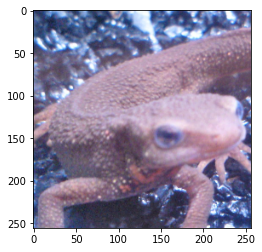

In [28]:
img_base_url = "https://yoyoyo-yo.github.io/Gasyori100knock/"
img_orig = io.imread(img_base_url + "dataset/images/imori_256x256.png")
plt.imshow(img_orig)

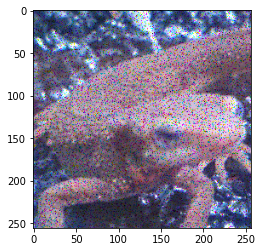

In [29]:
img_noise_orig = io.imread(img_base_url + 'dataset/images/imori_256x256_noise.png')
plt.imshow(img_noise_orig)

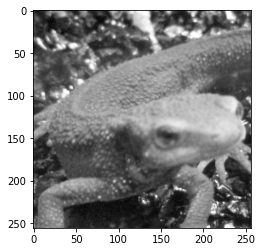

In [30]:
img_gray = cv2.cvtColor(img_orig, cv2.COLOR_RGB2GRAY)
plt.imshow(img_gray, cmap='gray')

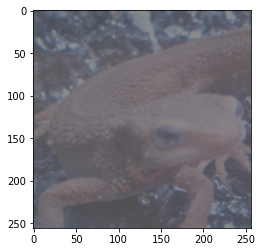

In [31]:
img_dark = io.imread('https://yoyoyo-yo.github.io/Gasyori100knock/dataset/images/imori_256x256_dark.png')
plt.imshow(img_dark)

In [32]:
img_gray = cv2.cvtColor(img_orig, cv2.COLOR_RGB2GRAY)

## Question 31 アフィン変換（スキュー） Affine transmation (skew)

1. アフィン変換を用いて、X-sharing(dx = 30)画像を作成せよ。
2. アフィン変換を用いて、Y-sharing(dy = 30)画像を作成せよ。
3. アフィン変換を用いて、幾何変換した(dx = 30, dy = 30)画像を作成せよ。

このような画像はスキュー画像と呼ばれ、画像を斜め方向に伸ばした画像である。

出力(1)の場合、x方向にdxだけ引き伸ばした画像はX-shearingと呼ばれる。

出力(2)の場合、y方向にdyだけ引き伸ばした画像はY-shearingと呼ばれる。

それぞれ次式のアフィン変換で実現できる。 ただし、元画像のサイズがh x wとする。

![](https://raw.githubusercontent.com/yoyoyo-yo/Gasyori100knock/master/questions/question_31_40/images/affine_xysharing.png)

In [37]:
def affine(img, affine_mat, out_shape):
    h, w, ch = img.shape

    [a, b, tx], [c, d, ty] = affine_mat
    out_h, out_w = out_shape

    out = np.zeros([out_h, out_w, ch])

    img_pad = np.pad(img, [(1, 1), (1, 1), (0, 0)])
    # img_pad = img

    xs, ys = np.meshgrid(range(out_w), range(out_h))

    _xs = np.maximum(np.minimum((1 / (a * d - b * c) * (d * xs - b * ys) - tx).astype(int) + 1, w + 1), 0)
    _ys = np.maximum(np.minimum((1 / (a * d - b * c) * (-c * xs + a * ys) - ty).astype(int) + 1, h + 1), 0)

    out[ys, xs] = img_pad[_ys, _xs]
    return np.clip(out, 0, 255).astype(np.uint8)

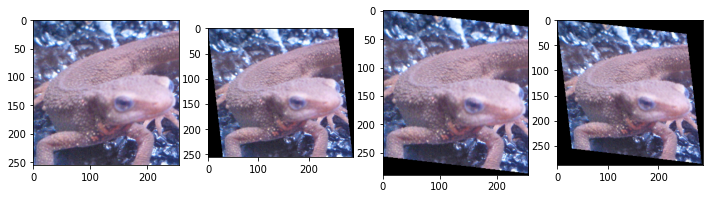

In [38]:
h, w, c = img_orig.shape

plt.figure(figsize=(12, 9))
plt.subplot(1, 4, 1); plt.imshow(img_orig)
plt.subplot(1, 4, 2); plt.imshow(affine(img_orig, [[1, 30 / w, 0], [0, 1, 0]], (h, int(w * 1.13))))
plt.subplot(1, 4, 3); plt.imshow(affine(img_orig, [[1, 0, 0], [30 / h, 1, 0]], (int(h * 1.13), w)))
plt.subplot(1, 4, 4); plt.imshow(affine(img_orig, [[1, 30 / w, 0], [30 / h, 1, 0]], (int(h * 1.13), int(w * 1.13))))
plt.show()

## Question 32 フーリエ変換 Fourier transformation

二次元離散フーリエ変換（DFT）を実装し、グレースケールの周波数のパワースペクトルを表示せよ。また、逆二次元離散フーリエ変換（IDFT）で画像を復元せよ。

二次元離散フーリエ変換（DFT: Discrete Fourier Transformation）とはフーリエ変換の画像に対する処理方法である。

通常のフーリエ変換はアナログ信号や音声などの連続値かつ一次元を対象に周波数成分を求める計算処理である。一方、ディジタル画像は\[0, 255\]の離散値をとり、かつ画像はHxWの二次元表示であるので、二次元離散フーリエ変換が行われる。

二次元離散フーリエ変換（DFT）は次式で計算される。

K = \[0, W-1\], I = \[0, H-1\], 入力画像をIとして

![](https://raw.githubusercontent.com/yoyoyo-yo/Gasyori100knock/master/questions/question_31_40/images/dft.png)

ここではグレースケール画像から二次元離散フーリエ変換を行う。

パワースペクトル：Gは複素数で表されるので、Gの絶対値を求めることである。今回のみ画像表示の時はパワースペクトルは\[0, 255\]にスケーリングせよ。

逆二次元離散フーリエ変換（IDFT: Inverse DFT）とは周波数成分Gから元の画像を復元する手法であり、次式で定義される。

x = \[0, W-1\], y = \[0, H-1\]として

![](https://raw.githubusercontent.com/yoyoyo-yo/Gasyori100knock/master/questions/question_31_40/images/idft.png)

上が定義式であるが、exp(j)は複素数の値をとってしまうので、実際にコードにするときは下式のように絶対値を使う。

![](https://raw.githubusercontent.com/yoyoyo-yo/Gasyori100knock/master/questions/question_31_40/images/idft_abs.png)

> 画像の高周波成分は細かい描き込みの成分で、画像の低周波成分はだいたいの輪郭などの成分

> 基本手的に低周波成分の方が多く含まれている

In [5]:
# DFT
def dft(img):
    H, W = img.shape
    G = np.zeros((H, W), dtype=complex)
    x, y = np.meshgrid(np.arange(0, W), np.arange(0, H))

    for l in range(H):
        for k in range(W):
            G[l, k] = np.sum(img * np.exp(-2j * np.pi * (x * k / W + y * l / H)))

    return G

# IDFT
def idft(G):
    H, W = G.shape
    out = np.zeros((H, W), dtype=np.float32)
    x, y = np.meshgrid(np.arange(0, W), np.arange(0, H))
    
    for l in range(H):
        for k in range(W):
            out[l, k] = np.abs(np.sum(G * np.exp(2j * np.pi * (x * k / W + y * l / H)))) / (H * W)

    # clipping
    out = np.clip(out, 0, 255)
    out = out.astype(np.uint8)
    return out

# DFT
G = dft(img_gray)

# power spectrum
ps = (np.abs(G) / np.abs(G).max() * 255).astype(np.uint8)

# IDFT
out = idft(G)

plt.subplot(1, 3, 1)
plt.title("input")
plt.imshow(img_gray, cmap="gray")
plt.subplot(1, 3, 2)
plt.title("after DFT & IDFT")
plt.imshow(out, cmap="gray")
plt.subplot(1, 3, 3)
plt.title("power spectrum")
plt.imshow(ps)
plt.show()

NameError: name 'img_gray' is not defined

In [19]:
# 複素数型
type(1j)

complex

In [3]:
img_balloon = cv2.imread("color/Balloon.bmp")
img_balloon = img_balloon[..., ::-1]

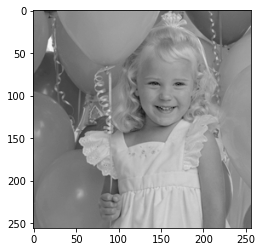

In [4]:
balloon_gray = cv2.cvtColor(img_balloon, cv2.COLOR_RGB2GRAY)
plt.imshow(balloon_gray, cmap='gray')

In [8]:
# DFT
G = dft(balloon_gray)

# power spectrum
ps = (np.abs(G) / np.abs(G).max() * 255).astype(np.uint8)

# IDFT
out = idft(G)

plt.subplot(1, 3, 1)
plt.title("input")
plt.imshow(balloon_gray, cmap="gray")
plt.subplot(1, 3, 2)
plt.title("after DFT & IDFT")
plt.imshow(out, cmap="gray")
plt.subplot(1, 3, 3)
plt.title("power spectrum")
plt.imshow(ps)
plt.show()

## Question 33 フーリエ変換 ローパスフィルタ

ローパスフィルタを通してIDFTで画像を復元せよ。
DFTによって得られた周波数成分は左上、右上、左下、右下に近いほど低周波数の成分を含んでいることになり、中心に近いほど高周波成分を示す。

![](https://raw.githubusercontent.com/yoyoyo-yo/Gasyori100knock/master/questions/question_31_40/images/lpf.png)

画像における高周波成分とは色が変わっている部分（ノイズや輪郭など）を示し、低周波成分とは色があまり変わっていない部分（夕日のグラデーションなど）を表す。 ここでは、高周波成分をカットし、低周波成分のみを通すローパスフィルタを実装せよ。

ここでは低周波数の中心から高周波までの距離をrとすると0.5rまでの成分を通すとする。

In [22]:
def lpf(G, ratio=0.5):
    H, W = G.shape
    h_half = H // 2
    w_half = W // 2
    
    # transfer positions
    _G = np.zeros_like(G)
    _G[:h_half, :w_half] = G[h_half:, w_half:]
    _G[:h_half, w_half:] = G[h_half:, :w_half]
    _G[h_half:, :w_half] = G[:h_half, w_half:]
    _G[h_half:, w_half:] = G[:h_half, :w_half]

    # filtering
    x, y = np.meshgrid(np.arange(0, W) - w_half, np.arange(0, H) - h_half)

    r = np.sqrt(x ** 2 + y ** 2)
    mask = np.ones((H, W), dtype=np.float32)
    mask[r > (h_half * ratio)] = 0
    _G *= mask

    # reverse original positions
    out = np.zeros_like(_G)
    out[:h_half, :w_half] = _G[h_half:, w_half:]
    out[:h_half, w_half:] = _G[h_half:, :w_half]
    out[h_half:, :w_half] = _G[:h_half, w_half:]
    out[h_half:, w_half:] = _G[:h_half, :w_half]

    return out


G_lpf = lpf(G)
out_lpf = idft(G_lpf)

plt.subplot(1, 2, 1)
plt.title("input")
plt.imshow(img_gray, cmap="gray")
plt.subplot(1, 2, 2)
plt.title("low pass filter")
plt.imshow(out_lpf, cmap="gray")
plt.show()

## Question 34 フーリエ変換 ハイパスフィルタ

ハイパスフィルタを通してIDFTで画像を復元せよ。

ここでは、低周波成分をカットし、高周波成分のみを通すハイパスフィルタを実装せよ。

ここでは低周波数の中心から高周波までの距離をrとすると0.1rからの成分を通すとする。


In [ ]:
def hpf(G, ratio=0.1):
    H, W = G.shape
    h_half = H // 2
    w_half = W // 2
    
    # transfer positions
    _G = np.zeros_like(G)
    _G[:h_half, :w_half] = G[h_half:, w_half:]
    _G[:h_half, w_half:] = G[h_half:, :w_half]
    _G[h_half:, :w_half] = G[:h_half, w_half:]
    _G[h_half:, w_half:] = G[:h_half, :w_half]

    # filtering
    x, y = np.meshgrid(np.arange(0, W) - w_half, np.arange(0, H) - h_half)
    r = np.sqrt(x ** 2 + y ** 2)
    mask = np.ones((H, W), dtype=np.float32)
    mask[r < (h_half * ratio)] = 0
    _G *= mask

    # reverse original positions
    out = np.zeros_like(_G)
    out[:h_half, :w_half] = _G[h_half:, w_half:]
    out[:h_half, w_half:] = _G[h_half:, :w_half]
    out[h_half:, :w_half] = _G[:h_half, w_half:]
    out[h_half:, w_half:] = _G[:h_half, :w_half]

    return out


G_hpf = hpf(G)
out_hpf = idft(G_hpf)

plt.subplot(1, 2, 1)
plt.title("input")
plt.imshow(img_gray_128, cmap="gray")
plt.subplot(1, 2, 2)
plt.title("high pass filter")
plt.imshow(out_hpf, cmap="gray")
plt.show()

## Question 35 フーリエ変換 バンドパスフィルタ

ハイパスフィルタを通してIDFTで画像を復元せよ。

ここでは、低周波成分と高周波成分の中間の周波数成分のみを通すハイパスフィルタを実装せよ。

ここでは低周波数の中心から高周波までの距離をrとすると0.1rから0.5rまでの成分を通すとする。


In [ ]:
def bpf(G, low=0.1, high=0.5):
    H, W = G.shape
    h_half = H // 2
    w_half = W // 2
    
    # transfer positions
    _G = np.zeros_like(G)
    _G[:h_half, :w_half] = G[h_half:, w_half:]
    _G[:h_half, w_half:] = G[h_half:, :w_half]
    _G[h_half:, :w_half] = G[:h_half, w_half:]
    _G[h_half:, w_half:] = G[:h_half, :w_half]

    # filtering
    x, y = np.meshgrid(np.arange(0, W) - w_half, np.arange(0, H) - h_half)
    r = np.sqrt(x ** 2 + y ** 2)
    mask = np.ones((H, W), dtype=np.float32)
    mask[(r < (h_half * low)) | (r > (h_half * high))] = 0
    _G *= mask

    # reverse original positions
    out = np.zeros_like(_G)
    out[:h_half, :w_half] = _G[h_half:, w_half:]
    out[:h_half, w_half:] = _G[h_half:, :w_half]
    out[h_half:, :w_half] = _G[:h_half, w_half:]
    out[h_half:, w_half:] = _G[:h_half, :w_half]

    return out


G_bpf = bpf(G)
out_bpf = idft(G_bpf)

plt.subplot(1, 2, 1)
plt.title("input")
plt.imshow(img_gray_128, cmap="gray")
plt.subplot(1, 2, 2)
plt.title("band pass filter")
plt.imshow(out_bpf, cmap="gray")
plt.show()